# 🧱 GANs on Lego Data - Training

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the GAN](#build)
3. [Train the GAN](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU, ReLU, UpSampling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
Z_DIM = 128
EPOCHS = 100
NUM_FEATURES = 128

## 1. Prepare the data <a name="prepare"></a>

In [4]:
train_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.
Using 32000 files for training.


2022-04-17 10:42:22.546376: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2022-04-17 10:42:22.546432: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-04-17 10:42:22.546751: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 40000 files belonging to 1 classes.
Using 8000 files for validation.


In [5]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 128.0) / 128.0
    return img

train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

In [6]:
train_sample = sample_batch(train)
test_sample = sample_batch(test)

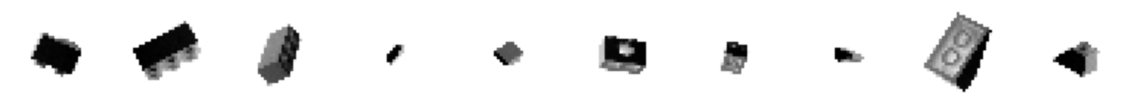

In [7]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [8]:

discriminator_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(discriminator_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation="sigmoid")(x)

discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                             

In [9]:
generator_input = Input(shape=(Z_DIM,))
x = Dense(4*4*NUM_FEATURES)(generator_input)
x = Reshape((4, 4, NUM_FEATURES))(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
generator_output = Conv2D(CHANNELS, kernel_size=3, padding="same", activation="tanh")(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                           

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]


    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Train the discriminator on fake images
        with tf.GradientTape() as tape:
            labels = tf.ones((batch_size, 1))
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
            predictions = self.discriminator(generated_images)
            d_fake_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_fake_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        # Train the discriminator on real images
        with tf.GradientTape() as tape:
            labels = tf.zeros((batch_size, 1))
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
            predictions = self.discriminator(real_images)
            d_real_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_real_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        d_loss = (d_fake_loss + d_real_loss) / 2

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## 3. Train the GAN <a name="train"></a>

In [11]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs2")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 128 + 128
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        


In [12]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [13]:
gan.compile(
    d_optimizer=Adam(learning_rate=0.00005),
    g_optimizer=Adam(learning_rate=0.0002),
    loss_fn=BinaryCrossentropy(),
)

Epoch 1/1000
100/100 [==============================] - ETA: 0s - d_loss: 0.5502 - g_loss: 0.9715
Saved to ./output/generated_img_000.png


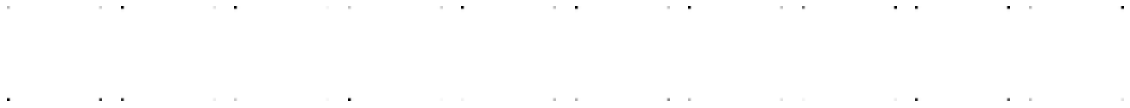

100/100 [==============================] - 63s 611ms/step - d_loss: 0.5502 - g_loss: 0.9715
Epoch 2/1000
100/100 [==============================] - ETA: 0s - d_loss: 0.1323 - g_loss: 2.6580
Saved to ./output/generated_img_001.png


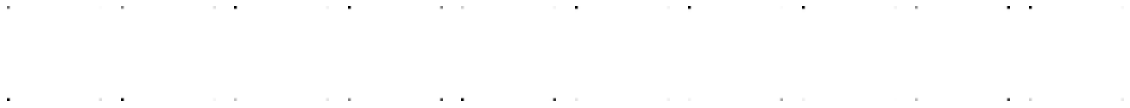

100/100 [==============================] - 62s 615ms/step - d_loss: 0.1323 - g_loss: 2.6580
Epoch 3/1000
  2/100 [..............................] - ETA: 59s - d_loss: 0.0564 - g_loss: 3.6632 

KeyboardInterrupt: 

In [14]:
history = gan.fit(
    train.repeat(), 
    epochs=EPOCHS*10, 
    steps_per_epoch = 100, 
    # initial_epoch = 105,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")